# 과제 (1)

## 20223888 이선우

## 1. 다음의 코드를 실행하여, 다중선형회귀모형 훈련과 평가를 위한 데이터셋, Xtrain, ytrain, Xtest, ytest를 생성하고 물음에 답하여라

In [23]:
import numpy as np

In [24]:
np.random.seed(123)
Xtrain = 2 * np.random.rand(100, 3)
ytrain = 6 + Xtrain @ np.array([[3], [2], [5]]) + np.random.rand(100,1)
Xtest = 2 * np.random.rand(20, 3)
ytest = 6 + Xtest @ np.array([[3], [2], [5]]) + np.random.randn(20, 1)

### 1-(1) w_pred 만들기

배치경사하강법 = 전체 학습 데이터를 이용해 학습 <br>
학습률 = 0.01 <br>
iters = 5000 <br>

In [25]:
def gradient_descent_steps(Xtrain, Ytrain, iters, learning_rate=0.01):

    sample_size = len(Xtrain)
    features_size = len(Xtrain.T)
    X = np.c_[np.ones((sample_size, 1)), Xtrain]
    
    weight = np.random.randn(features_size+1, 1)

    for i in range(iters):
        gradients = 1/sample_size * (X.T @ (X @ weight - Ytrain)) 
        weight = weight - learning_rate * gradients
        
    return weight

In [26]:
w_pred = gradient_descent_steps(Xtrain, ytrain, iters=5000)
print('w_pred =', w_pred, sep='\n')

w_pred =
[[6.50554133]
 [3.03535706]
 [1.97058984]
 [4.97678638]]


따라서 절편항을 제외한 w_pred를 구할 수 있다. iter를 늘리면 더욱 정확한 값을 추정하게 된다.

아래는 패키지를 이용한 값이다.

In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(Xtrain, ytrain)
lr.coef_

array([[3.01169904, 1.94586411, 4.9573312 ]])

### 1-(2) 다중선형회귀모델의 성능 MSE 평가

In [28]:
def mse_rmse_rsquare_finder (w_pred, Xtest, Ytest):
    X = np.c_[np.ones((len(Xtest), 1)), Xtest]
    sse = ((X @ w_pred - Ytest)**2).sum()
    sst = ((Ytest - Ytest.mean())**2).sum()
    mse = sse/len(Ytest)
    rmse = mse**0.5
    r_square = 1 - (sse/sst)

    return mse, rmse, r_square

In [29]:
mse, rmse, r_square = mse_rmse_rsquare_finder(w_pred, Xtest, ytest)
print('MSE =', np.around(mse, 6), 'RMSE =', np.around(rmse, 6), sep=' ')

MSE = 1.361625 RMSE = 1.166887


MSE 값이 작으므로 예측값과 실제값의 차이가 크지 않다는 것을 알 수 있다.

아래 패키지를 이용한 검산 결과 역시 계산 결과와 같다

In [30]:
from sklearn.metrics import mean_squared_error
X = np.c_[np.ones((len(Xtest), 1)), Xtest]
np.around(mean_squared_error(ytest, X @ w_pred), 6)

1.361625

## 2. sklearn의 california housing 을 이용해 물음에 답하라

아래 데이터 전처리에서, 특성변수들의 값을 스케일링 해 주었다.

In [31]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

cali_house = fetch_california_housing()
scaler = StandardScaler()

cali_house_X = pd.DataFrame(cali_house.data, columns=cali_house['feature_names'])
cali_house_Y = pd.DataFrame(cali_house.target, columns=['target'])

X_data = scaler.fit(cali_house_X).transform(cali_house_X)
y_target = cali_house.target

## 2-(1) 주어진 데이터 셋을 훈련자료 60%, 평가자료 40%로 나누어라

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_target, train_size=0.6, test_size=0.4, random_state=777)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(12384, 8) (8256, 8) (12384,) (8256,)


### 2-(2) 주어진 자료에 대해 릿지회귀 적용시, 규제조절 매개변수 중 최적의 값 선택

5-fold 교차검증 (cv=5) 적용 <br>
규제조절 매개변수 리스트 [0, 1, 10, 30, 50, 100] <br>
MSE 이용 <br>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alpha = 0 -> MSE = 0.523047
alpha = 1 -> MSE = 0.523045
alpha = 10 -> MSE = 0.523052
alpha = 30 -> MSE = 0.523207
alpha = 50 -> MSE = 0.523526
alpha = 100 -> MSE = 0.524894


Smallest MSE when alpha = "1"




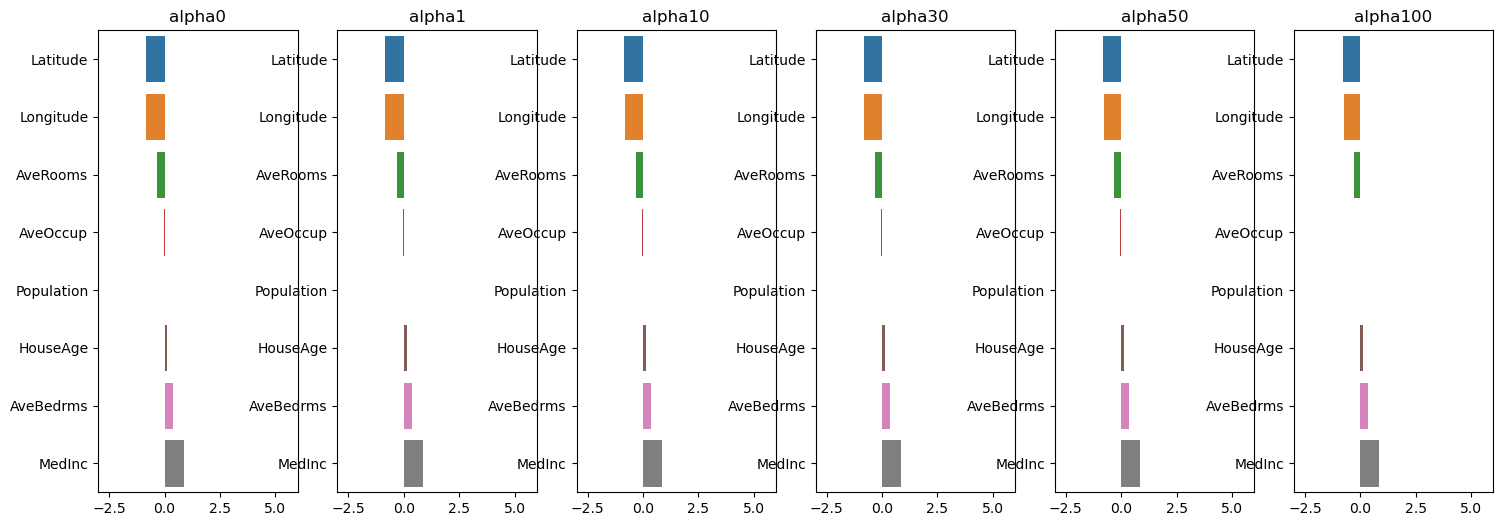

In [34]:
lambdas = [0, 1, 10, 30, 50, 100]
#lambdas = np.linspace(0, 100, 10000)
MSE_dict = {}

for l in lambdas:

    ridge = Ridge(alpha=l)
    neg_mse_scores = cross_val_score(ridge, X_train, Y_train,\
                                     scoring='neg_mean_squared_error',\
                                     cv=5)

    avg_mse = np.mean((-neg_mse_scores))
    MSE_dict[l] = avg_mse

    print(f'alpha = {l} -> MSE = {np.around(avg_mse, decimals=6)}')
    
    alpha = min(MSE_dict, key=MSE_dict.get)

print('\n')
print(f'Smallest MSE when alpha = "{alpha}"')
print('\n')

fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=len(lambdas))
coeff_df = pd.DataFrame()

for idx, l in enumerate(lambdas):

    ridge = Ridge(alpha=l)
    ridge.fit(X_train, Y_train)
    coeff = pd.Series(data=ridge.coef_, index=cali_house['feature_names'])
    coeff = coeff.sort_values(ascending=True)
    colname = 'alpha' + str(l)

    axs[idx].set_title(colname)
    axs[idx].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[idx])
    coeff_df[colname]=coeff

### 2-(3) 선택된 $\lambda$ 를 이용한 릿지회귀 훈련 후, 가중치 파라미터 추정치 출력후 평가자료를 이용해 $R^2$ 구하기

In [35]:
print(f'Smallest MSE when alpha = "{alpha}"')

ridge = Ridge(alpha=alpha)
ridge.fit(X_train, Y_train)
print('coef:', np.around(ridge.coef_, 6), 'intercept:', np.around(ridge.intercept_, 6), sep='\n')

Smallest MSE when alpha = "1"
coef:
[ 8.60795e-01  1.22837e-01 -3.24316e-01  3.79869e-01 -2.66000e-04
 -3.30930e-02 -8.63573e-01 -8.41163e-01]
intercept:
2.067778


가중치 패러미터는 위와 같다

In [36]:
pred = np.hstack((ridge.intercept_, ridge.coef_)).T
mse, rmse, r_squared = mse_rmse_rsquare_finder(pred, X_test, Y_test)
print('R^2 =', np.around(r_squared, 6), 'MSE =', np.around(mse, 6), sep=' ')

R^2 = 0.596844 MSE = 0.53106


위 훈련 자료를 통해 $R^2$ 의 값을 구한 것은 위와 같다.

아래 r2_score 모듈을 이용한 결과와 같음을 알 수 있다.

In [37]:
from sklearn.metrics import r2_score
a = ridge.predict(X_test)
np.around(r2_score(Y_test, a), 6)
#np.around(mean_squared_error(Y_test, a), 6)

0.596844

### 3. 일반 선형 회귀모형에 비해, Lasso 규제를 적용한 Lasso 회귀모형의 특징 중 가장 적절한 것은?

답: 3

coefficient 추정을 규제하는 Shrinkage methods가 사용되는 Lasso 회귀 모형은 위 방법을 통해 Bias를 증가시키는 대신, Variance를 줄이기 위해 노력한다. 따라서 원래 목적인 분산을 줄이는 과정에서 편향이 증가하는 폭이 작다면, 예측력이 높아지게 된다.